In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp

In [2]:
net = cv2.dnn.readNetFromDarknet(r"cfg\yolov4-obj.cfg",r"backup\yolov4-obj_6000.weights")

In [3]:
classes = ['Goalkeeper','Kicker','Football','Goalpost']

In [5]:
cap = cv2.VideoCapture('30.mp4')

mpDraw=mp.solutions.drawing_utils
mpPose=mp.solutions.pose
pose=mpPose.Pose()

while 1:
    success, img=cap.read()
    img = cv2.resize(img,(1280,720))
    hight,width,_ = img.shape
    imgRGB=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    results = pose.process(imgRGB)
    
    if results.pose_landmarks:
        mpDraw.draw_landmarks(img,results.pose_landmarks, mpPose.POSE_CONNECTIONS)
        for id, lm in enumerate(results.pose_landmarks.landmark):
            h, w, c =img.shape
            print(id, lm)
            cx,cy= int(lm.x*w), int(lm.y*h)
            cv2.circle(img, (cx,cy),5 , (255,0,0),cv2.FILLED)
    
    
    blob = cv2.dnn.blobFromImage(img, 1/255,(416,416),(0,0,0),swapRB = True,crop= False)

    net.setInput(blob)

    output_layers_name = net.getUnconnectedOutLayersNames()

    layerOutputs = net.forward(output_layers_name)

    boxes =[]
    confidences = []
    class_ids = []

    for output in layerOutputs:
        for detection in output:
            score = detection[5:]
            class_id = np.argmax(score)
            confidence = score[class_id]
            if confidence > 0.7:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * hight)
                w = int(detection[2] * width)
                h = int(detection[3]* hight)
                x = int(center_x - w/2)
                y = int(center_y - h/2)
                boxes.append([x,y,w,h])
                confidences.append((float(confidence)))
                class_ids.append(class_id)


    indexes = cv2.dnn.NMSBoxes(boxes,confidences,.5,.4)

    boxes =[]
    confidences = []
    class_ids = []

    for output in layerOutputs:
        for detection in output:
            score = detection[5:]
            class_id = np.argmax(score)
            confidence = score[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * hight)
                w = int(detection[2] * width)
                h = int(detection[3]* hight)

                x = int(center_x - w/2)
                y = int(center_y - h/2)



                boxes.append([x,y,w,h])
                confidences.append((float(confidence)))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes,confidences,.8,.4)
    font = cv2.FONT_HERSHEY_PLAIN
    colors = np.random.uniform(0,255,size =(len(boxes),3))
    if  len(indexes)>0:
        for i in indexes.flatten():
            x,y,w,h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = str(round(confidences[i],2))
            color = colors[i]
            cv2.rectangle(img,(x,y),(x+w,y+h),color,2)
            cv2.putText(img,label + " " + confidence, (x,y+400),font,2,color,2)

    cv2.imshow('img',img)
    if cv2.waitKey(1) == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

In [4]:
import cv2
import numpy as np
import mediapipe as mp

In [5]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [6]:
def draw_landmarks(image, results):
    
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    

In [7]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [8]:

def draw_styled_landmarks(image, results):
    # Draw face connections
  
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
  

In [11]:
cap=cv2.VideoCapture('round2.mp4')

feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
color = np.random.randint(0, 255, (100, 3))



whT=320
classesFile='data\obj.names'
classNames=[]
confThreshold=0.5
nmsThreshold=0.3



mpDraw=mp.solutions.drawing_utils
mpPose=mp.solutions.pose
pose=mpPose.Pose()

with open(classesFile,'rt') as f:
    classNames=f.read().rstrip('\n').split('\n')

#print(classNames)
#print(len(classNames))
modelConfiguration='cfg\yolov4-obj.cfg'
modelWeights='backup\yolov4-obj_6000.weights'

net=cv2.dnn.readNetFromDarknet(modelConfiguration,modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)


def findObjects(outputs,img):
    hT, wT, cT=img.shape
    bbox= []
    classIds=[]
    confs=[]
    for output in outputs:
        for detection in output:
            scores=detection[5:]
            #print(scores)
            classId=np.argmax(scores)
            confidence=scores[classId]
            #print(confidence)
            if confidence > confThreshold:
                w,h=int(detection[2]*wT), int(detection[3]*hT)
                x,y=int((detection[0]*wT) - w/2), int((detection[1]*hT) - h/2)
                bbox.append([x,y,w,h])
                classIds.append(classId)
                confs.append(float(confidence))
    #print(len(bbox))
    indices=cv2.dnn.NMSBoxes(bbox,confs,confThreshold,nmsThreshold)
    #print(indices)
    for i in indices.flatten():
        box = bbox[i]
        x, y, w, h = box[0], box[1], box[2], box[3]
        label=str(classNames[classIds[i]])
        confi=str(int(confs[i]*100))+'%'
        '''
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 255), 2)
        cv2.putText(img, label + " " + confi,
                   (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 255), 2)
        '''
        if label == 'Goalpost':
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)
            cv2.putText(img, label + " " + confi,
                        (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 255), 2)
            goal = img[y:y + h, x:x + w]
            cv2.line(goal, (x+70,y-h),(x+70, y + h),(0,255,0),3)
            cv2.line(goal, (x-w, y ), (x+w, y ), (0, 255, 0), 3)
            cv2.putText(img,  "1" ,
                        (x+10, y+20 ), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)
            cv2.putText(img, "2",
                        (x + w-20, y + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
            cv2.putText(img, "3",
                        (x + 10, y + h - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
            cv2.putText(img, "4",
                        (x + w - 20, y + h-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        if label=='Kicker':
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 255), 2)
            cv2.putText(img,label+" "+confi,
                        (x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,255),2)
            kicker=img[y:y+h, x:x+w] 
            with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.3) as holistic:
               # ashol  jinissh
                image, results =mediapipe_detection(kicker, holistic)
                print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
               


            

        if label == 'Football':
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 2)
            cv2.putText(img, label + " " + confi,
                        (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 255), 2)

            football = img[y:y + h, x:x + w]




        if label == 'Goalkeeper':
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
            cv2.putText(img, label + " " + confi,
                        (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 255), 2)


while True:
    success,img =cap.read()
    img = cv2.resize(img, (1280, 720))

    # print(results.pose_landmarks)


    blob=cv2.dnn.blobFromImage(img,1/255,(whT,whT),[0,0,0],1,crop=False)
    net.setInput(blob)

    
    layerNames=net.getLayerNames()
    #print(layerNames)
    outputNames=[layerNames[i[0]-1] for i in net.getUnconnectedOutLayers()]


    #print(outputNames)
    #print(net.getUnconnectedOutLayers())

    outputs=net.forward(outputNames)
    #print(outputs[0].shape)
    #print(outputs[1].shape)
    #print(outputs[2].shape)
    #print(outputs[0][0])

    findObjects(outputs,img)
    cv2.imshow('Image',img)
    cv2.waitKey(10)

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>


KeyboardInterrupt: 

In [16]:
cap = cv2.VideoCapture("round2.mp4")
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.3) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-c2l3r8zm\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [12]:
import cv2
import numpy as np
import mediapipe as mp

cap=cv2.VideoCapture('football/0/16.mp4')

feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
color = np.random.randint(0, 255, (100, 3))



whT=320
classesFile='data\obj.names'
classNames=[]
confThreshold=0.5
nmsThreshold=0.3



mpDraw=mp.solutions.drawing_utils
mpPose=mp.solutions.pose
pose=mpPose.Pose()

with open(classesFile,'rt') as f:
    classNames=f.read().rstrip('\n').split('\n')

#print(classNames)
#print(len(classNames))
modelConfiguration='cfg\yolov4-obj.cfg'
modelWeights='backup\yolov4-obj_6000.weights'

net=cv2.dnn.readNetFromDarknet(modelConfiguration,modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)



def findObjects(outputs,img):
    hT, wT, cT=img.shape
    bbox= []
    classIds=[]
    confs=[]
    for output in outputs:
        for detection in output:
            scores=detection[5:]
            #print(scores)
            classId=np.argmax(scores)
            confidence=scores[classId]
            #print(confidence)
            if confidence > confThreshold:
                w,h=int(detection[2]*wT), int(detection[3]*hT)
                x,y=int((detection[0]*wT) - w/2), int((detection[1]*hT) - h/2)
                bbox.append([x,y,w,h])
                classIds.append(classId)
                confs.append(float(confidence))
    #print(len(bbox))
    indices=cv2.dnn.NMSBoxes(bbox,confs,confThreshold,nmsThreshold)
    #print(indices)
    for i in indices.flatten():
        box = bbox[i]
        x, y, w, h = box[0], box[1], box[2], box[3]
        label=str(classNames[classIds[i]])
        confi=str(int(confs[i]*100))+'%'

        if label == 'Goalpost':
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)
            cv2.putText(img, label + " " + confi,
                        (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 255), 2)
            goal = img[y:y + h, x:x + w]
            cv2.line(goal, (x+70,y-h),(x+70, y + h),(0,255,0),3)
            cv2.line(goal, (x-w, y ), (x+w, y ), (0, 255, 0), 3)
            cv2.putText(img,  "1" ,
                        (x+10, y+20 ), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)
            cv2.putText(img, "2",
                        (x + w-20, y + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
            cv2.putText(img, "3",
                        (x + 10, y + h - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
            cv2.putText(img, "4",
                        (x + w - 20, y + h-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        if label=='Kicker':
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 255), 2)
            cv2.putText(img,label+" "+confi,
                        (x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,255),2)
            kicker=img[y:y+h, x:x+w] 
            imgRGB = cv2.cvtColor(kicker, cv2.COLOR_BGR2RGB)
            results = pose.process(imgRGB)
            if results.pose_landmarks:
                mpDraw.draw_landmarks(kicker, results.pose_landmarks, mpPose.POSE_CONNECTIONS)
                for id, lm in enumerate(results.pose_landmarks.landmark):
                    h, w, c = kicker.shape
                    print(id, lm)
                    cx, cy = int(lm.x * w), int(lm.y * h)
                    cv2.circle(kicker, (cx, cy), 5, (255, 0, 0), cv2.FILLED)
                    return results


while True:
    success,img =cap.read()
    img = cv2.resize(img, (1280, 720))

    #print(results.pose_landmarks)


    blob=cv2.dnn.blobFromImage(img,1/255,(whT,whT),[0,0,0],1,crop=False)
    net.setInput(blob)

    
    layerNames=net.getLayerNames()
    #print(layerNames)
    outputNames=[layerNames[i[0]-1] for i in net.getUnconnectedOutLayers()]


    #print(outputNames)
    #print(net.getUnconnectedOutLayers())

    outputs=net.forward(outputNames)
    #print(outputs[0].shape)
    #print(outputs[1].shape)
    #print(outputs[2].shape)
    #print(outputs[0][0])
    
    results=findObjects(outputs,img)
    #print(results)
    cv2.imshow('Image',img)
    cv2.waitKey(10)

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-_xlv4eex\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [9]:
results.pose_landmarks.landmark[0]

NameError: name 'results' is not defined

In [10]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    return np.concatenate([pose])

In [11]:
result_test = extract_keypoints(results)
result_test

NameError: name 'results' is not defined

In [12]:
extract_keypoints(results).shape

NameError: name 'results' is not defined

In [13]:
np.save('0', result_test)

NameError: name 'result_test' is not defined

In [14]:
np.load('0.npy')

array([ 0.38039947,  0.13915244, -0.39219895,  0.98875797,  0.3522763 ,
        0.1288918 , -0.42398626,  0.98640114,  0.34534344,  0.12916899,
       -0.4240796 ,  0.98287827,  0.44623309,  0.14863013, -0.42426223,
        0.98636061,  0.38793916,  0.12845933, -0.42960516,  0.98218292,
        0.40951872,  0.12863439, -0.42964807,  0.97941381,  0.42158109,
        0.12880464, -0.43012005,  0.98439676,  0.34681717,  0.13314684,
       -0.50509208,  0.98104376,  0.40342513,  0.13685912, -0.51902127,
        0.96749663,  0.38797495,  0.15222828, -0.40287656,  0.98093212,
        0.42088732,  0.15272862, -0.40738475,  0.97168851,  0.36234662,
        0.2266728 , -0.43841752,  0.99743956,  0.51888281,  0.21547316,
       -0.57645643,  0.99702406,  0.42062101,  0.35535237, -0.43653017,
        0.50758362,  0.6212129 ,  0.32317144, -0.51383734,  0.84982622,
        0.52726173,  0.47821245, -0.38346058,  0.527547  ,  0.67374879,
        0.3930808 , -0.31913549,  0.84102643,  0.4892073 ,  0.50

In [15]:
# Path for exported data, numpy arrays
import os
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(["0","1","2","3", "4"])
# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [16]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [20]:
cap=cv2.VideoCapture('football/4/18.mp4')

feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
color = np.random.randint(0, 255, (100, 3))



whT=320
classesFile='data\obj.names'
classNames=[]
confThreshold=0.5
nmsThreshold=0.3



mpDraw=mp.solutions.drawing_utils
mpPose=mp.solutions.pose
pose=mpPose.Pose()

with open(classesFile,'rt') as f:
    classNames=f.read().rstrip('\n').split('\n')

#print(classNames)
#print(len(classNames))
modelConfiguration='cfg\yolov4-obj.cfg'
modelWeights='backup\yolov4-obj_6000.weights'

net=cv2.dnn.readNetFromDarknet(modelConfiguration,modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)



def findObjects(outputs,img,sequence,fram_num):
    hT, wT, cT=img.shape
    bbox= []
    classIds=[]
    confs=[]
    for output in outputs:
        for detection in output:
            scores=detection[5:]
            #print(scores)
            classId=np.argmax(scores)
            confidence=scores[classId]
            #print(confidence)
            if confidence > confThreshold:
                w,h=int(detection[2]*wT), int(detection[3]*hT)
                x,y=int((detection[0]*wT) - w/2), int((detection[1]*hT) - h/2)
                bbox.append([x,y,w,h])
                classIds.append(classId)
                confs.append(float(confidence))
    #print(len(bbox))
    indices=cv2.dnn.NMSBoxes(bbox,confs,confThreshold,nmsThreshold)
    #print(indices)
    for i in indices.flatten():
        box = bbox[i]
        x, y, w, h = box[0], box[1], box[2], box[3]
        label=str(classNames[classIds[i]])
        confi=str(int(confs[i]*100))+'%'
      
        if label == 'Goalpost':
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)
            cv2.putText(img, label + " " + confi,
                        (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 255), 2)
            goal = img[y:y + h, x:x + w]
            cv2.line(goal, (x+70,y-h),(x+70, y + h),(0,255,0),3)
            cv2.line(goal, (x-w, y ), (x+w, y ), (0, 255, 0), 3)
            cv2.putText(img,  "1" ,
                        (x+10, y+20 ), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)
            cv2.putText(img, "2",
                        (x + w-20, y + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
            cv2.putText(img, "3",
                        (x + 10, y + h - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
            cv2.putText(img, "4",
                        (x + w - 20, y + h-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        if label=='Kicker':
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 255), 2)
            cv2.putText(img,label+" "+confi,
                        (x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,255),2)
            
            
            kicker=img[y:y+h, x:x+w] 
            imgRGB = cv2.cvtColor(kicker, cv2.COLOR_BGR2RGB)
            results = pose.process(imgRGB)
            if results.pose_landmarks:
                mpDraw.draw_landmarks(kicker, results.pose_landmarks, mpPose.POSE_CONNECTIONS)
                for id, lm in enumerate(results.pose_landmarks.landmark):
                    h, w, c = kicker.shape
                    print(id, lm)
                    cx, cy = int(lm.x * w), int(lm.y * h)
                    cv2.circle(kicker, (cx, cy), 5, (255, 0, 0), cv2.FILLED)
                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(DATA_PATH, "4", str(sequence), str(frame_num))
                    np.save(npy_path, keypoints)


while True:
    
    for sequence in range(9,30):
            # Loop through video length aka sequence length
        for frame_num in range(sequence_length):

            success,img =cap.read()
            img = cv2.resize(img, (1280, 720))

                        # print(results.pose_landmarks)


            blob=cv2.dnn.blobFromImage(img,1/255,(whT,whT),[0,0,0],1,crop=False)
            net.setInput(blob)


            layerNames=net.getLayerNames()
                        #print(layerNames)
            outputNames=[layerNames[i[0]-1] for i in net.getUnconnectedOutLayers()]


                        #print(outputNames)
                        #print(net.getUnconnectedOutLayers())

            outputs=net.forward(outputNames)
                        #print(outputs[0].shape)
                        #print(outputs[1].shape)
                        #print(outputs[2].shape)
                        #print(outputs[0][0])

            findObjects(outputs,img,sequence,frame_num)
            cv2.imshow('Image',img)
            cv2.waitKey(10)

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-_xlv4eex\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [17]:
!pip install tensorflow-gpu==2.4.1

You should consider upgrading via the 'c:\users\asus\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [70]:
!pip install keras==2.3.1
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0


You should consider upgrading via the 'c:\users\asus\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


  Cloning https://www.github.com/keras-team/keras-contrib.git to c:\users\asus\appdata\local\temp\pip-req-build-eubxy8i7
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101669 sha256=632d44d415bf403909896bfdaea16a74a1a5892db13425f28eca87be22cccd67
  Stored in directory: C:\Users\Asus\AppData\Local\Temp\pip-ephem-wheel-cache-3f563hwm\wheels\bb\1f\f2\b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git 'C:\Users\Asus\AppData\Local\Temp\pip-req-build-eubxy8i7'
You should consider upgrading via the 'c:\users\asus\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [18]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [19]:
label_map = {label:num for num, label in enumerate(actions)}

In [20]:
label_map

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}

In [20]:
no_sequence=30
sequence_length=

SyntaxError: invalid syntax (Temp/ipykernel_8472/1702933291.py, line 2)

In [21]:
sequences, labels = [], []
for action in actions:
    for sequence in range(0,3):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [22]:
np.array(sequences).shape

(15, 30, 132)

In [23]:
np.array(labels).shape

(15,)

In [24]:
X = np.array(sequences)

In [25]:
X.shape

(15, 30, 132)

In [21]:
y = to_categorical(labels).astype(int)
y

NameError: name 'labels' is not defined

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

NameError: name 'X' is not defined

In [23]:
y_test.shape

NameError: name 'y_test' is not defined

In [24]:
X_train.shape

NameError: name 'X_train' is not defined

In [26]:
actions.shape[0]

5

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf


In [27]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [28]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,132)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [32]:
res = [.7, 0.2, 0.1]

In [33]:
actions[np.argmax(res)]

'0'

In [92]:
!pip install pydot
!pip install graphviz

  Using cached pydot-1.4.2-py2.py3-none-any.whl (21 kB)


You should consider upgrading via the 'c:\users\asus\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\asus\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [29]:
from keras.utils.vis_utils import plot_model



model.summary()
plot_model(
model, to_file='model.png', show_shapes=False, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

Using TensorFlow backend.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            50432     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 205,061
Trainable params: 205,061
Non-trainable params: 0
__________________________________________________

TypeError: plot_model() got an unexpected keyword argument 'show_dtype'

In [39]:
from keras.utils.vis_utils import pydot
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Using TensorFlow backend.


OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [30]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [35]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss')<0.2):
            print("\nReached 90% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks=myCallback()
validation_data=(X_test, y_test)

NameError: name 'X_test' is not defined

In [125]:
from tensorflow.keras.callbacks import CSVLogger
csv_logger = CSVLogger('training.log')
history=model.fit(X_train, y_train, epochs=500,validation_data=validation_data,callbacks=[csv_logger])

Epoch 1/500
1/1 [==============================] - 0s 385ms/step - loss: 2.5634e-04 - categorical_accuracy: 1.0000 - val_loss: 10.0924 - val_categorical_accuracy: 0.0000e+00
Epoch 2/500
1/1 [==============================] - 0s 54ms/step - loss: 2.5530e-04 - categorical_accuracy: 1.0000 - val_loss: 10.0963 - val_categorical_accuracy: 0.0000e+00
Epoch 3/500
1/1 [==============================] - 0s 50ms/step - loss: 2.5383e-04 - categorical_accuracy: 1.0000 - val_loss: 10.1000 - val_categorical_accuracy: 0.0000e+00
Epoch 4/500
1/1 [==============================] - 0s 53ms/step - loss: 2.5204e-04 - categorical_accuracy: 1.0000 - val_loss: 10.1034 - val_categorical_accuracy: 0.0000e+00
Epoch 5/500
1/1 [==============================] - 0s 50ms/step - loss: 2.5086e-04 - categorical_accuracy: 1.0000 - val_loss: 10.1080 - val_categorical_accuracy: 0.0000e+00
Epoch 6/500
1/1 [==============================] - 0s 55ms/step - loss: 2.5029e-04 - categorical_accuracy: 1.0000 - val_loss: 10.1142 

1/1 [==============================] - 0s 43ms/step - loss: 1.8858e-04 - categorical_accuracy: 1.0000 - val_loss: 10.4805 - val_categorical_accuracy: 0.0000e+00
Epoch 96/500
1/1 [==============================] - 0s 49ms/step - loss: 1.8542e-04 - categorical_accuracy: 1.0000 - val_loss: 10.4831 - val_categorical_accuracy: 0.0000e+00
Epoch 97/500
1/1 [==============================] - 0s 47ms/step - loss: 1.8489e-04 - categorical_accuracy: 1.0000 - val_loss: 10.4856 - val_categorical_accuracy: 0.0000e+00
Epoch 98/500
1/1 [==============================] - 0s 47ms/step - loss: 1.8481e-04 - categorical_accuracy: 1.0000 - val_loss: 10.4879 - val_categorical_accuracy: 0.0000e+00
Epoch 99/500
1/1 [==============================] - 0s 61ms/step - loss: 1.8452e-04 - categorical_accuracy: 1.0000 - val_loss: 10.4901 - val_categorical_accuracy: 0.0000e+00
Epoch 100/500
1/1 [==============================] - 0s 69ms/step - loss: 1.8397e-04 - categorical_accuracy: 1.0000 - val_loss: 10.4922 - val_c

Epoch 142/500
1/1 [==============================] - 0s 76ms/step - loss: 1.6053e-04 - categorical_accuracy: 1.0000 - val_loss: 10.6213 - val_categorical_accuracy: 0.0000e+00
Epoch 143/500
1/1 [==============================] - 0s 48ms/step - loss: 1.6038e-04 - categorical_accuracy: 1.0000 - val_loss: 10.6244 - val_categorical_accuracy: 0.0000e+00
Epoch 144/500
1/1 [==============================] - 0s 53ms/step - loss: 1.6022e-04 - categorical_accuracy: 1.0000 - val_loss: 10.6273 - val_categorical_accuracy: 0.0000e+00
Epoch 145/500
1/1 [==============================] - 0s 44ms/step - loss: 1.5982e-04 - categorical_accuracy: 1.0000 - val_loss: 10.6300 - val_categorical_accuracy: 0.0000e+00
Epoch 146/500
1/1 [==============================] - 0s 48ms/step - loss: 1.5923e-04 - categorical_accuracy: 1.0000 - val_loss: 10.6327 - val_categorical_accuracy: 0.0000e+00
Epoch 147/500
1/1 [==============================] - 0s 48ms/step - loss: 1.5850e-04 - categorical_accuracy: 1.0000 - val_los

Epoch 189/500
1/1 [==============================] - 0s 46ms/step - loss: 1.4018e-04 - categorical_accuracy: 1.0000 - val_loss: 10.7490 - val_categorical_accuracy: 0.0000e+00
Epoch 190/500
1/1 [==============================] - 0s 45ms/step - loss: 1.3994e-04 - categorical_accuracy: 1.0000 - val_loss: 10.7512 - val_categorical_accuracy: 0.0000e+00
Epoch 191/500
1/1 [==============================] - 0s 51ms/step - loss: 1.3954e-04 - categorical_accuracy: 1.0000 - val_loss: 10.7534 - val_categorical_accuracy: 0.0000e+00
Epoch 192/500
1/1 [==============================] - 0s 68ms/step - loss: 1.3897e-04 - categorical_accuracy: 1.0000 - val_loss: 10.7556 - val_categorical_accuracy: 0.0000e+00
Epoch 193/500
1/1 [==============================] - 0s 68ms/step - loss: 1.3823e-04 - categorical_accuracy: 1.0000 - val_loss: 10.7576 - val_categorical_accuracy: 0.0000e+00
Epoch 194/500
1/1 [==============================] - 0s 70ms/step - loss: 1.3761e-04 - categorical_accuracy: 1.0000 - val_los

Epoch 236/500
1/1 [==============================] - 0s 56ms/step - loss: 1.2272e-04 - categorical_accuracy: 1.0000 - val_loss: 10.8621 - val_categorical_accuracy: 0.0000e+00
Epoch 237/500
1/1 [==============================] - 0s 63ms/step - loss: 1.2251e-04 - categorical_accuracy: 1.0000 - val_loss: 10.8640 - val_categorical_accuracy: 0.0000e+00
Epoch 238/500
1/1 [==============================] - 0s 92ms/step - loss: 1.2211e-04 - categorical_accuracy: 1.0000 - val_loss: 10.8659 - val_categorical_accuracy: 0.0000e+00
Epoch 239/500
1/1 [==============================] - 0s 72ms/step - loss: 1.2160e-04 - categorical_accuracy: 1.0000 - val_loss: 10.8677 - val_categorical_accuracy: 0.0000e+00
Epoch 240/500
1/1 [==============================] - 0s 50ms/step - loss: 1.2098e-04 - categorical_accuracy: 1.0000 - val_loss: 10.8699 - val_categorical_accuracy: 0.0000e+00
Epoch 241/500
1/1 [==============================] - 0s 47ms/step - loss: 1.2055e-04 - categorical_accuracy: 1.0000 - val_los

Epoch 283/500
1/1 [==============================] - 0s 47ms/step - loss: 1.0770e-04 - categorical_accuracy: 1.0000 - val_loss: 10.9613 - val_categorical_accuracy: 0.0000e+00
Epoch 284/500
1/1 [==============================] - 0s 46ms/step - loss: 1.0772e-04 - categorical_accuracy: 1.0000 - val_loss: 10.9631 - val_categorical_accuracy: 0.0000e+00
Epoch 285/500
1/1 [==============================] - 0s 44ms/step - loss: 1.0714e-04 - categorical_accuracy: 1.0000 - val_loss: 10.9651 - val_categorical_accuracy: 0.0000e+00
Epoch 286/500
1/1 [==============================] - 0s 46ms/step - loss: 1.0691e-04 - categorical_accuracy: 1.0000 - val_loss: 10.9670 - val_categorical_accuracy: 0.0000e+00
Epoch 287/500
1/1 [==============================] - 0s 50ms/step - loss: 1.0665e-04 - categorical_accuracy: 1.0000 - val_loss: 10.9688 - val_categorical_accuracy: 0.0000e+00
Epoch 288/500
1/1 [==============================] - 0s 79ms/step - loss: 1.0640e-04 - categorical_accuracy: 1.0000 - val_los

Epoch 330/500
1/1 [==============================] - 0s 61ms/step - loss: 9.5272e-05 - categorical_accuracy: 1.0000 - val_loss: 11.0512 - val_categorical_accuracy: 0.0000e+00
Epoch 331/500
1/1 [==============================] - 0s 49ms/step - loss: 9.5025e-05 - categorical_accuracy: 1.0000 - val_loss: 11.0536 - val_categorical_accuracy: 0.0000e+00
Epoch 332/500
1/1 [==============================] - 0s 47ms/step - loss: 9.4795e-05 - categorical_accuracy: 1.0000 - val_loss: 11.0560 - val_categorical_accuracy: 0.0000e+00
Epoch 333/500
1/1 [==============================] - 0s 47ms/step - loss: 9.4625e-05 - categorical_accuracy: 1.0000 - val_loss: 11.0584 - val_categorical_accuracy: 0.0000e+00
Epoch 334/500
1/1 [==============================] - 0s 47ms/step - loss: 9.4429e-05 - categorical_accuracy: 1.0000 - val_loss: 11.0607 - val_categorical_accuracy: 0.0000e+00
Epoch 335/500
1/1 [==============================] - 0s 47ms/step - loss: 9.4148e-05 - categorical_accuracy: 1.0000 - val_los

Epoch 377/500
1/1 [==============================] - 0s 70ms/step - loss: 8.5152e-05 - categorical_accuracy: 1.0000 - val_loss: 11.1359 - val_categorical_accuracy: 0.0000e+00
Epoch 378/500
1/1 [==============================] - 0s 58ms/step - loss: 8.4862e-05 - categorical_accuracy: 1.0000 - val_loss: 11.1377 - val_categorical_accuracy: 0.0000e+00
Epoch 379/500
1/1 [==============================] - 0s 46ms/step - loss: 8.4556e-05 - categorical_accuracy: 1.0000 - val_loss: 11.1396 - val_categorical_accuracy: 0.0000e+00
Epoch 380/500
1/1 [==============================] - 0s 47ms/step - loss: 8.4377e-05 - categorical_accuracy: 1.0000 - val_loss: 11.1409 - val_categorical_accuracy: 0.0000e+00
Epoch 381/500
1/1 [==============================] - 0s 48ms/step - loss: 8.4139e-05 - categorical_accuracy: 1.0000 - val_loss: 11.1421 - val_categorical_accuracy: 0.0000e+00
Epoch 382/500
1/1 [==============================] - 0s 46ms/step - loss: 8.4002e-05 - categorical_accuracy: 1.0000 - val_los

Epoch 424/500
1/1 [==============================] - 0s 45ms/step - loss: 7.6188e-05 - categorical_accuracy: 1.0000 - val_loss: 11.2112 - val_categorical_accuracy: 0.0000e+00
Epoch 425/500
1/1 [==============================] - 0s 47ms/step - loss: 7.5899e-05 - categorical_accuracy: 1.0000 - val_loss: 11.2130 - val_categorical_accuracy: 0.0000e+00
Epoch 426/500
1/1 [==============================] - 0s 46ms/step - loss: 7.5610e-05 - categorical_accuracy: 1.0000 - val_loss: 11.2150 - val_categorical_accuracy: 0.0000e+00
Epoch 427/500
1/1 [==============================] - 0s 54ms/step - loss: 7.6061e-05 - categorical_accuracy: 1.0000 - val_loss: 11.2166 - val_categorical_accuracy: 0.0000e+00
Epoch 428/500
1/1 [==============================] - 0s 67ms/step - loss: 7.5261e-05 - categorical_accuracy: 1.0000 - val_loss: 11.2184 - val_categorical_accuracy: 0.0000e+00
Epoch 429/500
1/1 [==============================] - 0s 75ms/step - loss: 7.5209e-05 - categorical_accuracy: 1.0000 - val_los

Epoch 471/500
1/1 [==============================] - 0s 45ms/step - loss: 6.8357e-05 - categorical_accuracy: 1.0000 - val_loss: 11.2755 - val_categorical_accuracy: 0.0000e+00
Epoch 472/500
1/1 [==============================] - 0s 52ms/step - loss: 6.8255e-05 - categorical_accuracy: 1.0000 - val_loss: 11.2766 - val_categorical_accuracy: 0.0000e+00
Epoch 473/500
1/1 [==============================] - 0s 59ms/step - loss: 6.8110e-05 - categorical_accuracy: 1.0000 - val_loss: 11.2781 - val_categorical_accuracy: 0.0000e+00
Epoch 474/500
1/1 [==============================] - 0s 68ms/step - loss: 6.7931e-05 - categorical_accuracy: 1.0000 - val_loss: 11.2799 - val_categorical_accuracy: 0.0000e+00
Epoch 475/500
1/1 [==============================] - 0s 70ms/step - loss: 6.7719e-05 - categorical_accuracy: 1.0000 - val_loss: 11.2821 - val_categorical_accuracy: 0.0000e+00
Epoch 476/500
1/1 [==============================] - 0s 60ms/step - loss: 6.7633e-05 - categorical_accuracy: 1.0000 - val_los

In [120]:
!pip3 install pandas

  Using cached pandas-1.3.4-cp37-cp37m-win_amd64.whl (10.0 MB)
  Using cached pytz-2021.3-py2.py3-none-any.whl (503 kB)


You should consider upgrading via the 'c:\users\asus\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [36]:
import pandas
his = pandas.read_csv('E:/Capstone_Main/darknet-master/darknet/build/darknet/x64/training.log') 
his.head()

,epoch,categorical_accuracy,loss,val_categorical_accuracy,val_loss
0,0,0.00,0.000256,0.00,10.092376
1,1,0.07,0.000255,0.00,10.096333
2,2,0.30,0.000254,0.00,10.100004
3,3,0.34,0.000252,0.01,10.103438
4,4,0.36,0.000251,0.01,10.108047


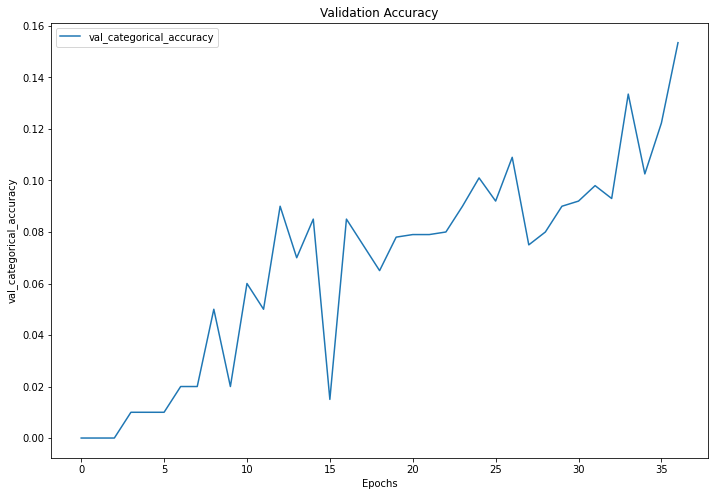

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40,8))

plt.subplot(131)
#plt.plot(his.epoch, his.loss, label="categorical_accuracy")
plt.plot(his.epoch, his.val_categorical_accuracy, label="val_categorical_accuracy")
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('val_categorical_accuracy')
plt.legend()
plt.savefig('accuracy.png',dpi=720)

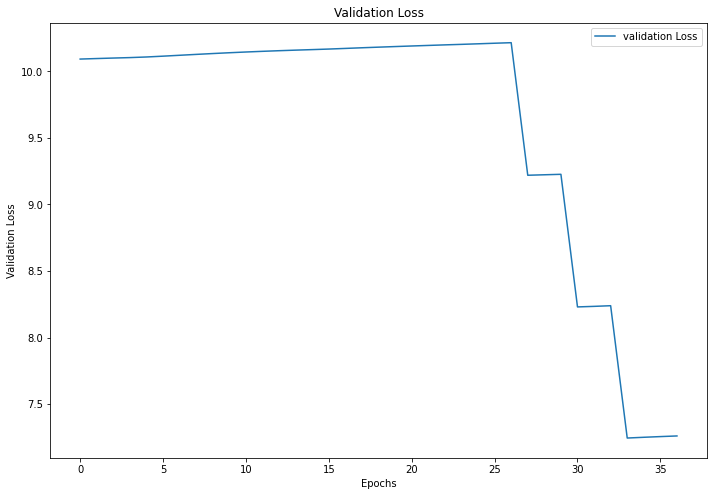

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40,8))

plt.subplot(131)
plt.plot(his.epoch, his.val_loss, label="validation Loss")
#plt.plot(his.epoch, his.val_loss, label="Validation")
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.savefig('accuracy.png',dpi=720)

In [130]:
model.save('football.h5')

In [31]:
model.load_weights('football.h5')

In [32]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [33]:
yhat = model.predict(X_test)

NameError: name 'X_test' is not defined

In [40]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

NameError: name 'y_test' is not defined

In [41]:
multilabel_confusion_matrix(ytrue, yhat)

NameError: name 'ytrue' is not defined

In [70]:
accuracy_score(ytrue, yhat)

0.5

In [71]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(ytrue, yhat)))

print('Micro Precision: {:.2f}'.format(precision_score(ytrue, yhat, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(ytrue, yhat, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(ytrue, yhat, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(ytrue, yhat, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(ytrue, yhat, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(ytrue, yhat, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(ytrue, yhat, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(ytrue, yhat, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(ytrue, yhat, average='weighted')))



Accuracy: 0.50

Micro Precision: 0.50
Micro Recall: 0.50
Micro F1-score: 0.50

Macro Precision: 0.25
Macro Recall: 0.50
Macro F1-score: 0.33

Weighted Precision: 0.25
Weighted Recall: 0.50
Weighted F1-score: 0.33


c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\asus\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
from scipy import stats

In [147]:
# 1. New detection variables
sequence = []

predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-3:]
        
        if len(sequence) == 3:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

NameError: name 'mp_holistic' is not defined

In [35]:
colors = [(245,117,16), (117,245,16), (16,117,245),(0,117,0),(255,0,245)]

In [33]:
!pip install collection

You should consider upgrading via the 'c:\users\asus\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.



  Created wheel for collection: filename=collection-0.1.6-py3-none-any.whl size=5117 sha256=e21a23ca8ff520793803ad7d12597d15f2139507dfaccb145c83f2c6f2b143e6
  Stored in directory: c:\users\asus\appdata\local\pip\cache\wheels\45\ed\3c\29a1c0600bb908a2e7421dc3a3775cbaed434a71b4ed93a439
Successfully built collection


In [ ]:
from collections import defaultdict
cap=cv2.VideoCapture('round2.mp4')

feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
#color = np.random.randint(0, 255, (100, 3))



whT=320
classesFile='data\obj.names'
classNames=[]
confThreshold=0.3
nmsThreshold=0.3
pts=[]
colors = [(245,117,16), (117,245,16), (16,117,245),(0,117,0),(255,0,245)]

mpDraw=mp.solutions.drawing_utils
mpPose=mp.solutions.pose
pose=mpPose.Pose()

with open(classesFile,'rt') as f:
    classNames=f.read().rstrip('\n').split('\n')

#print(classNames)
#print(len(classNames))
modelConfiguration='cfg\yolov4-obj.cfg'
modelWeights='backup\yolov4-obj_6000.weights'

net=cv2.dnn.readNetFromDarknet(modelConfiguration,modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

sequence = []
sentence = []
threshold = 0.3

def findObjects(outputs,img):
    sequence = []
    sentence = []
    hT, wT, cT=img.shape
    bbox= []
    classIds=[]
    confs=[]
    for output in outputs:
        for detection in output:
            scores=detection[5:]
            #print(scores)
            classId=np.argmax(scores)
            confidence=scores[classId]
            #print(confidence)
            if confidence > confThreshold:
                w,h=int(detection[2]*wT), int(detection[3]*hT)
                x,y=int((detection[0]*wT) - w/2), int((detection[1]*hT) - h/2)
                bbox.append([x,y,w,h])
                classIds.append(classId)
                confs.append(float(confidence))
    #print(len(bbox))
    indices=cv2.dnn.NMSBoxes(bbox,confs,confThreshold,nmsThreshold)
    #print(indices)
    for i in indices.flatten():
        box = bbox[i]
        x, y, w, h = box[0], box[1], box[2], box[3]
        label=str(classNames[classIds[i]])
        confi=str(int(confs[i]*100))+'%'
        global flag, pts
        
        centroi_dict=defaultdict(list)
        
        object_id_list=[]
        
        if label == 'Goalpost':
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)
            cv2.putText(img, label + " " + confi,
                        (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 255), 2)
            goal = img[y:y + h, x:x + w]
            cv2.line(goal, (x+70,y-h),(x+70, y + h),(0,255,0),3)
            cv2.line(goal, (x-w, y ), (x+w, y ), (0, 255, 0), 3)
            cv2.putText(img,  "1" ,
                        (x+10, y+20 ), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2)
            cv2.putText(img, "2",
                        (x + w-20, y + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
            cv2.putText(img, "3",
                        (x + 10, y + h - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
            cv2.putText(img, "4",
                        (x + w - 20, y + h-20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
        
        if label == 'Football':
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 255), 2)
            cv2.putText(img, label + " " + confi,
                        (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 255), 2)
            football = img[y:y + h, x:x + w]
            
            Cx=x+int(w/2)
            Cy= y+int(h/2)
            old_point = (Cx,Cy)
            pts.append(old_point)
            
            if len(pts)>1:
                for i in range(0, len(pts)):
                    # if either of the tracked points are None, ignore
                    # them
             #       if pts[i - 1] is None or pts[i] is None:
            
              #          continue

                    cv2.line(img, pts[i - 1], pts[i], (255, 0, 0), 2)    
            
         




        if label == 'Goalkeeper':
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
            cv2.putText(img, label + " " + confi,
                        (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 255), 2)
            
           

            
        if label=='Kicker':
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 255), 2)
            cv2.putText(img,label+" "+confi,
                        (x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,255),2)
            kicker=img[y:y+h, x:x+w] 
            imgRGB = cv2.cvtColor(kicker, cv2.COLOR_BGR2RGB)
            results = pose.process(imgRGB)
            if results.pose_landmarks:
                mpDraw.draw_landmarks(kicker, results.pose_landmarks, mpPose.POSE_CONNECTIONS)
                for id, lm in enumerate(results.pose_landmarks.landmark):
                    h, w, c = kicker.shape
                    print(id, lm)
                    cx, cy = int(lm.x * w), int(lm.y * h)
                    cv2.circle(kicker, (cx, cy), 5, (255, 0, 0), cv2.FILLED)
                    keypoints = extract_keypoints(results)
                    sequence.append(keypoints)
                    sequence = sequence[-30:]
                    
                    if len(sequence) == 30:
                        res = model.predict(np.expand_dims(sequence, axis=0))[0]
                        print(actions[np.argmax(res)])
                        print(res)

                        # Viz probabilities
                        
                        for num, prob in enumerate(res):
                            cv2.rectangle(img, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
                            cv2.putText(img, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
                            cv2.putText(img, str(int(prob*100)),(40,85+num*40) , cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
                   # cv2.rectangle(img, (0,0), (640, 40), (245, 117, 16), -1)
                   # cv2.putText(img, ' '.join(sentence), (3,30), 
                                #   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
     
    


while True:
    success,img =cap.read()
    img = cv2.resize(img, (1280, 720))

    #print(results.pose_landmarks)

    
    blob=cv2.dnn.blobFromImage(img,1/255,(whT,whT),[0,0,0],1,crop=False)
    net.setInput(blob)

    
    layerNames=net.getLayerNames()
    #print(layerNames)
    outputNames=[layerNames[i[0]-1] for i in net.getUnconnectedOutLayers()]


    #print(outputNames)
    #print(net.getUnconnectedOutLayers())

    outputs=net.forward(outputNames)
    #print(outputs[0].shape)
    #print(outputs[1].shape)
    #print(outputs[2].shape)
    #print(outputs[0][0])
    

    results=findObjects(outputs,img)
    #print(results)
    cv2.imshow('Image',img)
    cv2.waitKey(10)

0 x: 0.854680061340332
y: 0.24128803610801697
z: -0.011180453933775425
visibility: 0.9979525804519653

1 x: 0.8496993184089661
y: 0.2314646989107132
z: 0.014069044962525368
visibility: 0.9978733062744141

2 x: 0.8498488664627075
y: 0.2311423122882843
z: 0.013860076665878296
visibility: 0.9972025156021118

3 x: 0.8513113856315613
y: 0.2297261655330658
z: 0.013685712590813637
visibility: 0.9981392621994019

4 x: 0.8469789028167725
y: 0.23065827786922455
z: -0.06112223491072655
visibility: 0.9971359968185425

5 x: 0.8440629839897156
y: 0.22791095077991486
z: -0.06118226423859596
visibility: 0.9965150356292725

6 x: 0.8389846086502075
y: 0.22690434753894806
z: -0.0613025538623333
visibility: 0.9974678754806519

7 x: 0.8191101551055908
y: 0.22932307422161102
z: 0.1709357351064682
visibility: 0.9973127245903015

8 x: 0.8023965358734131
y: 0.22637498378753662
z: -0.17089428007602692
visibility: 0.9968240261077881

9 x: 0.8461577892303467
y: 0.24692334234714508
z: 0.05723956972360611
visibilit

4
[3.3743497e-08 1.6850836e-06 8.7851157e-07 9.2689504e-08 9.9999726e-01]
31 x: 0.24147693812847137
y: 0.8788633346557617
z: 0.27637118101119995
visibility: 0.2627462148666382

4
[3.3743497e-08 1.6850836e-06 8.7851157e-07 9.2689504e-08 9.9999726e-01]
32 x: 0.4633433222770691
y: 0.9018764495849609
z: 0.10129807889461517
visibility: 0.7293718457221985

4
[3.3743497e-08 1.6850836e-06 8.7851157e-07 9.2689504e-08 9.9999726e-01]
0 x: 0.7294140458106995
y: 0.12272880226373672
z: 1.1799181699752808
visibility: 0.9983211159706116

1 x: 0.7232464551925659
y: 0.10425136983394623
z: 1.054929256439209
visibility: 0.9983302354812622

2 x: 0.710254430770874
y: 0.10258155316114426
z: 1.0550521612167358
visibility: 0.9978357553482056

3 x: 0.6963785886764526
y: 0.10119931399822235
z: 1.05500066280365
visibility: 0.9984989762306213

4 x: 0.7559826970100403
y: 0.10759666562080383
z: 1.0187965631484985
visibility: 0.9977845549583435

5 x: 0.7665488719940186
y: 0.10832303762435913
z: 1.018594741821289
visi

31 x: 0.32151028513908386
y: 0.9207007884979248
z: 0.5833755731582642
visibility: 0.3721434772014618

4
[3.0114879e-11 1.8772647e-08 5.1063300e-09 1.9295122e-10 1.0000000e+00]
32 x: 0.5274959206581116
y: 0.9688768982887268
z: -0.4258520305156708
visibility: 0.7662133574485779

4
[3.0114879e-11 1.8772647e-08 5.1063300e-09 1.9295122e-10 1.0000000e+00]
0 x: 0.7303825616836548
y: 0.12226808071136475
z: 1.1503797769546509
visibility: 0.9986064434051514

1 x: 0.7235697507858276
y: 0.10406750440597534
z: 1.0167269706726074
visibility: 0.9986684322357178

2 x: 0.7113979458808899
y: 0.10216595977544785
z: 1.0166137218475342
visibility: 0.9982978701591492

3 x: 0.6986271142959595
y: 0.10050597786903381
z: 1.0165256261825562
visibility: 0.9987896084785461

4 x: 0.7545436024665833
y: 0.10777212679386139
z: 0.9650624394416809
visibility: 0.9982360005378723

5 x: 0.7648504972457886
y: 0.1085817739367485
z: 0.9646602869033813
visibility: 0.99787837266922

6 x: 0.7756052017211914
y: 0.1096322312951088

31 x: 0.4220685660839081
y: 0.8471817970275879
z: 0.6638333201408386
visibility: 0.44639772176742554

4
[6.7117056e-10 8.9948022e-09 3.2675480e-08 8.4295154e-10 1.0000000e+00]
32 x: 0.5320348143577576
y: 0.9067784547805786
z: -0.7203763127326965
visibility: 0.7985157370567322

4
[6.7117056e-10 8.9948022e-09 3.2675480e-08 8.4295154e-10 1.0000000e+00]
0 x: 0.7218996286392212
y: 0.15808475017547607
z: 0.9001478552818298
visibility: 0.9986953139305115

1 x: 0.7081155180931091
y: 0.14337167143821716
z: 0.8023416996002197
visibility: 0.9987766146659851

2 x: 0.6979808211326599
y: 0.14227145910263062
z: 0.8024703860282898
visibility: 0.9984972476959229

3 x: 0.6875951886177063
y: 0.14118552207946777
z: 0.8024460673332214
visibility: 0.9988671541213989

4 x: 0.7388046979904175
y: 0.1458461880683899
z: 0.760545551776886
visibility: 0.9983963966369629

5 x: 0.7485708594322205
y: 0.146455779671669
z: 0.7602421045303345
visibility: 0.9980719089508057

6 x: 0.7586281299591064
y: 0.14724849164485931

4
[6.4236097e-08 1.0667827e-06 1.7793495e-06 7.0711884e-08 9.9999702e-01]
31 x: 0.47854623198509216
y: 0.8420505523681641
z: 0.27464383840560913
visibility: 0.45046404004096985

4
[6.4236097e-08 1.0667827e-06 1.7793495e-06 7.0711884e-08 9.9999702e-01]
32 x: 0.5176085829734802
y: 0.8969270586967468
z: -0.6380714774131775
visibility: 0.7866889238357544

4
[6.4236097e-08 1.0667827e-06 1.7793495e-06 7.0711884e-08 9.9999702e-01]
0 x: 0.7222477793693542
y: 0.16938747465610504
z: 0.8670085668563843
visibility: 0.9980632066726685

1 x: 0.7141937017440796
y: 0.1551344394683838
z: 0.7649550437927246
visibility: 0.998410165309906

2 x: 0.704021155834198
y: 0.15362775325775146
z: 0.7650749683380127
visibility: 0.998114824295044

3 x: 0.6935771107673645
y: 0.1522654891014099
z: 0.7651768326759338
visibility: 0.9984959959983826

4 x: 0.7422293424606323
y: 0.1586485356092453
z: 0.7321323752403259
visibility: 0.9978888034820557

5 x: 0.7515836358070374
y: 0.1595718413591385
z: 0.7319328188896179
visib

31 x: 0.46736451983451843
y: 0.852811336517334
z: 0.2137201726436615
visibility: 0.43070074915885925

4
[5.9525155e-07 3.0609779e-04 1.9446119e-05 6.5085860e-06 9.9966741e-01]
32 x: 0.5037369728088379
y: 0.8794409036636353
z: -0.5198952555656433
visibility: 0.7267804741859436

4
[5.9525155e-07 3.0609779e-04 1.9446119e-05 6.5085860e-06 9.9966741e-01]
0 x: 0.7536798715591431
y: 0.131704181432724
z: 0.8566746115684509
visibility: 0.9969878196716309

1 x: 0.7458221912384033
y: 0.11529885232448578
z: 0.7478744983673096
visibility: 0.9976066946983337

2 x: 0.7325445413589478
y: 0.11310920119285583
z: 0.7478772401809692
visibility: 0.9972599744796753

3 x: 0.7187283635139465
y: 0.11111678183078766
z: 0.7476510405540466
visibility: 0.99766606092453

4 x: 0.7757192850112915
y: 0.11940567195415497
z: 0.7016894221305847
visibility: 0.9970216751098633

5 x: 0.7838037014007568
y: 0.12016365677118301
z: 0.7015151381492615
visibility: 0.9963182806968689

6 x: 0.7916990518569946
y: 0.12122398614883423

4
[7.2715938e-13 2.3801269e-10 7.5737433e-10 4.5861214e-12 1.0000000e+00]
31 x: 0.41495609283447266
y: 0.9008477330207825
z: -0.2843822240829468
visibility: 0.4739525020122528

4
[7.2715938e-13 2.3801269e-10 7.5737433e-10 4.5861214e-12 1.0000000e+00]
32 x: 0.46961575746536255
y: 0.9325689077377319
z: -1.0198885202407837
visibility: 0.7376863956451416

4
[7.2715938e-13 2.3801269e-10 7.5737433e-10 4.5861214e-12 1.0000000e+00]
0 x: 0.7556455731391907
y: 0.12013493478298187
z: 1.3506178855895996
visibility: 0.9971203207969666

1 x: 0.7401634454727173
y: 0.10350963473320007
z: 1.2655824422836304
visibility: 0.9977787733078003

2 x: 0.7252503633499146
y: 0.10191105306148529
z: 1.265528917312622
visibility: 0.997468888759613

3 x: 0.7105847597122192
y: 0.10056398063898087
z: 1.2653049230575562
visibility: 0.9978371262550354

4 x: 0.7740507125854492
y: 0.10602588951587677
z: 1.1946760416030884
visibility: 0.9972649812698364

5 x: 0.7819530963897705
y: 0.1061716228723526
z: 1.1945539712905884
v

31 x: 0.3179984986782074
y: 0.9215739965438843
z: 0.0007995886262506247
visibility: 0.5233237147331238

1
[8.4975920e-09 9.9998438e-01 1.1504913e-09 1.0782201e-05 4.8293928e-06]
32 x: 0.40242668986320496
y: 0.9158321022987366
z: -0.5026338696479797
visibility: 0.7738171815872192

1
[8.4975920e-09 9.9998438e-01 1.1504913e-09 1.0782201e-05 4.8293928e-06]
0 x: 0.7630159854888916
y: 0.12828154861927032
z: 1.0301604270935059
visibility: 0.9975005388259888

1 x: 0.7410508990287781
y: 0.11085234582424164
z: 0.9000321626663208
visibility: 0.9980316758155823

2 x: 0.7211807370185852
y: 0.10919229686260223
z: 0.9000949859619141
visibility: 0.9977878928184509

3 x: 0.7007815837860107
y: 0.10775617510080338
z: 0.8997666239738464
visibility: 0.9981024861335754

4 x: 0.7849274277687073
y: 0.11361110955476761
z: 0.833940327167511
visibility: 0.9976633191108704

5 x: 0.7958126664161682
y: 0.11388693749904633
z: 0.8339048027992249
visibility: 0.9971991181373596

6 x: 0.8068195581436157
y: 0.11447892338

31 x: 0.17576509714126587
y: 0.9634143710136414
z: -0.04101330041885376
visibility: 0.6071328520774841

2
[4.8408140e-07 8.7147038e-07 9.8926628e-01 9.3695754e-03 1.3629439e-03]
32 x: 0.4798303246498108
y: 0.8858081102371216
z: 0.2958729863166809
visibility: 0.8046988844871521

2
[4.8408140e-07 8.7147038e-07 9.8926628e-01 9.3695754e-03 1.3629439e-03]


In [50]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, img, colors))

NameError: name 'prob_viz' is not defined

<Figure size 1296x1296 with 0 Axes>

SyntaxError: invalid syntax (Temp/ipykernel_13632/1456198282.py, line 1)

In [181]:
len(actions)

5

In [212]:
for num, prob in enumerate(res):
    print(num)
    print(prob)

0
0.7
1
0.2
2
0.1


In [199]:
res

[0.7, 0.2, 0.1]

In [211]:
colors[2]

(16, 117, 245)

In [51]:
pts

[(637, 265),
 (637, 266),
 (638, 265),
 (637, 265),
 (638, 264),
 (637, 265),
 (638, 264),
 (637, 265),
 (637, 264),
 (637, 265),
 (637, 264),
 (637, 265),
 (636, 266),
 (637, 264),
 (637, 265),
 (637, 264),
 (637, 265),
 (637, 264),
 (637, 265),
 (637, 265),
 (637, 266),
 (637, 265),
 (638, 265),
 (638, 265),
 (638, 265),
 (637, 266),
 (637, 265),
 (638, 266),
 (638, 265),
 (638, 266),
 (638, 266),
 (638, 267),
 (637, 267),
 (637, 268),
 (637, 268),
 (637, 268),
 (637, 271),
 (637, 270),
 (643, 271),
 (645, 273),
 (643, 273),
 (643, 276),
 (642, 282),
 (643, 285),
 (636, 289),
 (641, 290),
 (640, 290),
 (641, 294),
 (641, 297),
 (644, 298),
 (647, 297),
 (650, 298),
 (654, 298),
 (666, 298),
 (672, 298),
 (676, 298),
 (683, 299),
 (693, 301),
 (699, 301),
 (712, 300),
 (736, 298),
 (741, 298),
 (750, 296),
 (758, 296),
 (765, 299),
 (773, 302),
 (775, 304),
 (783, 306),
 (789, 316),
 (789, 326),
 (797, 321),
 (816, 329),
 (825, 330),
 (828, 332),
 (829, 334),
 (839, 338),
 (843, 340),

In [27]:
pts[-3]

(666, 507)

In [40]:
centroi_dict

NameError: name 'centroi_dict' is not defined

In [41]:
object_id_list

NameError: name 'object_id_list' is not defined